In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np

data = np.load("/content/gdrive/MyDrive/Colab Notebooks/eng-chn_data.npz")
print(data.files) # ['enc_inputs', 'dec_inputs', 'dec_outputs', 'eng_vocab_size']

# Extract our desired data
enc_inputs = data["enc_inputs"]
dec_inputs = data["dec_inputs"]
dec_outputs = data["dec_outputs"]
eng_vocab_size = data["eng_vocab_size"].item(0)

['enc_inputs', 'dec_inputs', 'dec_outputs', 'eng_vocab_size']


In [ ]:
# shuffle X and y in unision
np.random.seed(42)
shuffler = np.random.permutation(enc_inputs.shape[0]) # 會產生一個 0 到 enc_inputs.shape[0] 的隨機排列
enc_inputs = enc_inputs[shuffler]
dec_inputs = dec_inputs[shuffler]
dec_outputs = dec_outputs[shuffler]

In [ ]:
from sklearn.model_selection import train_test_split


# prepare training and test data
test_ratio = .2
random_seed = 42

enc_inputs_train, enc_inputs_test = train_test_split(enc_inputs, test_size = test_ratio, shuffle = False)
dec_inputs_train, dec_inputs_test = train_test_split(dec_inputs, test_size = test_ratio, shuffle = False)
y_train, y_test = train_test_split(dec_outputs, test_size = test_ratio, shuffle = False)
X_train = [enc_inputs_train, dec_inputs_train]
X_test = [enc_inputs_test, dec_inputs_test]

In [ ]:
eng_max_seq_length = enc_inputs.shape[1]
chn_max_seq_length = dec_outputs.shape[1]
chn_vocab_size = dec_outputs.shape[2]

In [ ]:
print(enc_inputs.shape)
print(dec_inputs.shape)
print(dec_outputs.shape)

(10000, 11)
(10000, 22)
(10000, 22, 2455)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Activation, dot, concatenate
from tensorflow.keras.models import Model


# hyperparameters
src_wordEmbed_dim = 96
tgt_wordEmbed_dim = 100
latent_dim = 256

def build_seq2seq(src_max_seq_length, src_vocab_size, src_wordEmbed_dim, tgt_max_seq_length, tgt_vocab_size, tgt_wordEmbed_dim, latent_dim, model_name = None):
    """
    Builda an LSTM seq2seq model with Luong attention
    """
    # Build an encoder
    enc_inputs = Input(shape = (src_max_seq_length, ))
    # 例如："I am fine" → [14, 22, 36] → [[0.1, 0.4, ...], [0.8, ...], ...] （向量維度是 96）
    vectors = Embedding(input_dim = src_vocab_size, output_dim = src_wordEmbed_dim, name = "embedding_enc")(enc_inputs)  #shape 為 (batch_size, eng_max_seq_length, src_wordEmbed_dim)
    # 每一個時間步的 output，最後一個時間步的 hidden state（短期記憶）和 cell state（長期記憶）
    enc_outputs_1, enc_h1, enc_c1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_enc_LSTM")(vectors)
    enc_outputs_2, enc_h2, enc_c2 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "2nd_layer_enc_LSTM")(enc_outputs_1)
    enc_states = [enc_h1, enc_c1, enc_h2, enc_c2]

    # Build a decoder
    dec_inputs = Input(shape = (tgt_max_seq_length, ))
    vectors = Embedding(input_dim = tgt_vocab_size, output_dim = tgt_wordEmbed_dim, name = "embedding_dec")(dec_inputs)
    # 初始狀態使用 Encoder 第 1 層的 enc_h1, enc_c1
    dec_outputs_1, dec_h1, dec_c1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_dec_LSTM")(vectors, initial_state = [enc_h1, enc_c1])
    dec_outputs_2 = LSTM(latent_dim, return_sequences = True, return_state = False, name = "2nd_layer_dec_LSTM")(dec_outputs_1, initial_state = [enc_h2, enc_c2])

    # Luong Attention

    # 用 內積（dot product）計算 decoder outputs 和 encoder outputs  作為相似度（Luong Attention 中的 dot 方法）
    attention_scores = dot([dec_outputs_2, enc_outputs_2], axes = [2, 2])
    # 對 attention scores 做 softmax，得到每個 decoder time step 對 encoder 所有位置的權重（對應）。
    attenton_weights = Activation("softmax")(attention_scores)
    # 把 encoder 的 hidden states 用注意力權重做加權平均。
    context_vec = dot([attenton_weights, enc_outputs_2], axes = [2, 1])
    # 把 Context Vector 和 Decoder 合併
    ht_context_vec = concatenate([context_vec, dec_outputs_2], name = "concatentated_vector")
    # 經過 Dense 層轉換為 Attention 向量
    attention_vec = Dense(latent_dim, use_bias = False, activation = "tanh", name = "attentional_vector")(ht_context_vec)
    # 把前一層的 attention_vec（每時間點都是一個向量）轉換成對詞彙表上每個詞的 raw 分數（logits）。
    logits = TimeDistributed(Dense(tgt_vocab_size))(attention_vec)
    # Softmax 得到預測詞的機率分布
    dec_outputs_final = Activation("softmax", name = "softmax")(logits)

    # integrate as a model
    model = Model([enc_inputs, dec_inputs], dec_outputs_final, name = model_name)
    # compile model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
        loss = tf.keras.losses.CategoricalCrossentropy(),
    )
    return model

# build our seq2seq model
eng_cn_translator = build_seq2seq(
    src_max_seq_length = eng_max_seq_length,
    src_vocab_size = eng_vocab_size,
    src_wordEmbed_dim = src_wordEmbed_dim,
    tgt_max_seq_length = chn_max_seq_length,
    tgt_vocab_size = chn_vocab_size,
    tgt_wordEmbed_dim = tgt_wordEmbed_dim,
    latent_dim = latent_dim,
    model_name = "eng-chn_translator_v1"
    )
eng_cn_translator.summary()

Model: "eng-chn_translator_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_enc       │ (None, 11, 96)    │    295,680 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_dec       │ (None, 22, 100)   │    245,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 1st_layer_enc_LSTM  │ [(None, 11, 256), │    361,472 │ embedding_enc[0]… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 1st_layer_dec_LSTM  │ [(None, 22, 256), │    365,568 │ embedding_dec[0]… │
│ (LSTM)              │ (None, 256),      │            │ 1st_layer_enc_LS… │
│                     │ (None, 256)]      │            │ 1st_layer_enc_LS… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 2nd_layer_enc_LSTM  │ [(None, 11, 256), │    525,312 │ 1st_layer_enc_LS… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 2nd_layer_dec_LSTM  │ (None, 22, 256)   │    525,312 │ 1st_layer_dec_LS… │
│ (LSTM)              │                   │            │ 2nd_layer_enc_LS… │
│                     │                   │            │ 2nd_layer_enc_LS… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 22, 11)    │          0 │ 2nd_layer_dec_LS… │
│                     │                   │            │ 2nd_layer_enc_LS… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 22, 11)    │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 22, 256)   │          0 │ activation[0][0], │
│                     │                   │            │ 2nd_layer_enc_LS… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatentated_vect… │ (None, 22, 512)   │          0 │ dot_1[0][0],      │
│ (Concatenate)       │                   │            │ 2nd_layer_dec_LS… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attentional_vector  │ (None, 22, 256)   │    131,072 │ concatentated_ve… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 22, 2455)  │    630,935 │ attentional_vect… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 22, 2455)  │          0 │ time_distributed… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 3,080,851 (11.75 MB)

 Trainable params: 3,080,851 (11.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.92277, saving model to models/eng-cn_translator_v1.h5


100/100 - 10s - 104ms/step - loss: 2.6059 - val_loss: 1.9228
Epoch 2/200

Epoch 2: val_loss improved from 1.92277 to 1.57644, saving model to models/eng-cn_translator_v1.h5


100/100 - 4s - 36ms/step - loss: 1.7087 - val_loss: 1.5764
Epoch 3/200

Epoch 3: val_loss improved from 1.57644 to 1.35150, saving model to models/eng-cn_translator_v1.h5


100/100 - 4s - 42ms/step - loss: 1.4379 - val_loss: 1.3515
Epoch 4/200

Epoch 4: val_loss improved from 1.35150 to 1.17095, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 1.2456 - val_loss: 1.1709
Epoch 5/200

Epoch 5: val_loss improved from 1.17095 to 0.96465, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 1.0468 - val_loss: 0.9647
Epoch 6/200

Epoch 6: val_loss improved from 0.96465 to 0.84355, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 33ms/step - loss: 0.8847 - val_loss: 0.8435
Epoch 7/200

Epoch 7: val_loss improved from 0.84355 to 0.75667, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.7698 - val_loss: 0.7567
Epoch 8/200

Epoch 8: val_loss improved from 0.75667 to 0.68072, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 29ms/step - loss: 0.6873 - val_loss: 0.6807
Epoch 9/200

Epoch 9: val_loss improved from 0.68072 to 0.63327, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 29ms/step - loss: 0.6199 - val_loss: 0.6333
Epoch 10/200

Epoch 10: val_loss improved from 0.63327 to 0.58141, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 32ms/step - loss: 0.5651 - val_loss: 0.5814
Epoch 11/200

Epoch 11: val_loss improved from 0.58141 to 0.54929, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 49ms/step - loss: 0.5175 - val_loss: 0.5493
Epoch 12/200

Epoch 12: val_loss improved from 0.54929 to 0.51380, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 48ms/step - loss: 0.4745 - val_loss: 0.5138
Epoch 13/200

Epoch 13: val_loss improved from 0.51380 to 0.48259, saving model to models/eng-cn_translator_v1.h5


100/100 - 6s - 56ms/step - loss: 0.4388 - val_loss: 0.4826
Epoch 14/200

Epoch 14: val_loss improved from 0.48259 to 0.47027, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.4513 - val_loss: 0.4703
Epoch 15/200

Epoch 15: val_loss improved from 0.47027 to 0.43650, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 27ms/step - loss: 0.3853 - val_loss: 0.4365
Epoch 16/200

Epoch 16: val_loss improved from 0.43650 to 0.42379, saving model to models/eng-cn_translator_v1.h5


100/100 - 6s - 58ms/step - loss: 0.3584 - val_loss: 0.4238
Epoch 17/200

Epoch 17: val_loss improved from 0.42379 to 0.41638, saving model to models/eng-cn_translator_v1.h5


100/100 - 4s - 45ms/step - loss: 0.3529 - val_loss: 0.4164
Epoch 18/200

Epoch 18: val_loss improved from 0.41638 to 0.39157, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 30ms/step - loss: 0.3228 - val_loss: 0.3916
Epoch 19/200

Epoch 19: val_loss improved from 0.39157 to 0.37862, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 27ms/step - loss: 0.3035 - val_loss: 0.3786
Epoch 20/200

Epoch 20: val_loss improved from 0.37862 to 0.37633, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 32ms/step - loss: 0.2896 - val_loss: 0.3763
Epoch 21/200

Epoch 21: val_loss improved from 0.37633 to 0.36151, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.2774 - val_loss: 0.3615
Epoch 22/200

Epoch 22: val_loss improved from 0.36151 to 0.35988, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 29ms/step - loss: 0.2641 - val_loss: 0.3599
Epoch 23/200

Epoch 23: val_loss improved from 0.35988 to 0.34462, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.2520 - val_loss: 0.3446
Epoch 24/200

Epoch 24: val_loss improved from 0.34462 to 0.33738, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 30ms/step - loss: 0.2392 - val_loss: 0.3374
Epoch 25/200

Epoch 25: val_loss did not improve from 0.33738
100/100 - 3s - 31ms/step - loss: 0.2330 - val_loss: 0.3965
Epoch 26/200

Epoch 26: val_loss improved from 0.33738 to 0.32888, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 50ms/step - loss: 0.2447 - val_loss: 0.3289
Epoch 27/200

Epoch 27: val_loss improved from 0.32888 to 0.31781, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 29ms/step - loss: 0.2124 - val_loss: 0.3178
Epoch 28/200

Epoch 28: val_loss improved from 0.31781 to 0.31614, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 32ms/step - loss: 0.2008 - val_loss: 0.3161
Epoch 29/200

Epoch 29: val_loss improved from 0.31614 to 0.31089, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 46ms/step - loss: 0.1936 - val_loss: 0.3109
Epoch 30/200

Epoch 30: val_loss improved from 0.31089 to 0.31014, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.1885 - val_loss: 0.3101
Epoch 31/200

Epoch 31: val_loss did not improve from 0.31014
100/100 - 6s - 57ms/step - loss: 0.2188 - val_loss: 0.3449
Epoch 32/200

Epoch 32: val_loss improved from 0.31014 to 0.30222, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 27ms/step - loss: 0.1906 - val_loss: 0.3022
Epoch 33/200

Epoch 33: val_loss improved from 0.30222 to 0.29325, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 29ms/step - loss: 0.1685 - val_loss: 0.2933
Epoch 34/200

Epoch 34: val_loss did not improve from 0.29325
100/100 - 5s - 51ms/step - loss: 0.1612 - val_loss: 0.2954
Epoch 35/200

Epoch 35: val_loss improved from 0.29325 to 0.28801, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 33ms/step - loss: 0.1556 - val_loss: 0.2880
Epoch 36/200

Epoch 36: val_loss did not improve from 0.28801
100/100 - 3s - 25ms/step - loss: 0.1534 - val_loss: 0.2899
Epoch 37/200

Epoch 37: val_loss did not improve from 0.28801
100/100 - 2s - 25ms/step - loss: 0.1500 - val_loss: 0.2909
Epoch 38/200

Epoch 38: val_loss did not improve from 0.28801
100/100 - 3s - 25ms/step - loss: 0.1564 - val_loss: 0.3220
Epoch 39/200

Epoch 39: val_loss improved from 0.28801 to 0.28576, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 28ms/step - loss: 0.1511 - val_loss: 0.2858
Epoch 40/200

Epoch 40: val_loss improved from 0.28576 to 0.27959, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 50ms/step - loss: 0.1349 - val_loss: 0.2796
Epoch 41/200

Epoch 41: val_loss improved from 0.27959 to 0.27914, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 51ms/step - loss: 0.1300 - val_loss: 0.2791
Epoch 42/200

Epoch 42: val_loss improved from 0.27914 to 0.27851, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 55ms/step - loss: 0.1256 - val_loss: 0.2785
Epoch 43/200

Epoch 43: val_loss did not improve from 0.27851
100/100 - 5s - 47ms/step - loss: 0.1238 - val_loss: 0.2804
Epoch 44/200

Epoch 44: val_loss improved from 0.27851 to 0.27747, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.1241 - val_loss: 0.2775
Epoch 45/200

Epoch 45: val_loss improved from 0.27747 to 0.27314, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 31ms/step - loss: 0.1169 - val_loss: 0.2731
Epoch 46/200

Epoch 46: val_loss did not improve from 0.27314
100/100 - 3s - 31ms/step - loss: 0.1142 - val_loss: 0.2765
Epoch 47/200

Epoch 47: val_loss did not improve from 0.27314
100/100 - 5s - 46ms/step - loss: 0.1323 - val_loss: 0.2965
Epoch 48/200

Epoch 48: val_loss did not improve from 0.27314
100/100 - 3s - 28ms/step - loss: 0.1355 - val_loss: 0.2789
Epoch 49/200

Epoch 49: val_loss improved from 0.27314 to 0.26925, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 52ms/step - loss: 0.1061 - val_loss: 0.2693
Epoch 50/200

Epoch 50: val_loss improved from 0.26925 to 0.26536, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0996 - val_loss: 0.2654
Epoch 51/200

Epoch 51: val_loss improved from 0.26536 to 0.26382, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0953 - val_loss: 0.2638
Epoch 52/200

Epoch 52: val_loss did not improve from 0.26382
100/100 - 3s - 28ms/step - loss: 0.0940 - val_loss: 0.2643
Epoch 53/200

Epoch 53: val_loss did not improve from 0.26382
100/100 - 5s - 49ms/step - loss: 0.0917 - val_loss: 0.2656
Epoch 54/200

Epoch 54: val_loss did not improve from 0.26382
100/100 - 3s - 28ms/step - loss: 0.0900 - val_loss: 0.2646
Epoch 55/200

Epoch 55: val_loss did not improve from 0.26382
100/100 - 3s - 28ms/step - loss: 0.0890 - val_loss: 0.2649
Epoch 56/200

Epoch 56: val_loss did not improve from 0.26382
100/100 - 3s - 30ms/step - loss: 0.1191 - val_loss: 0.3105
Epoch 57/200

Epoch 57: val_loss did not improve from 0.26382
100/100 - 5s - 47ms/step - loss: 0.1012 - val_loss: 0.2674
Epoch 58/200

Epoch 58: val_loss improved from 0.26382 to 0.25766, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 52ms/step - loss: 0.0825 - val_loss: 0.2577
Epoch 59/200

Epoch 59: val_loss improved from 0.25766 to 0.25621, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 52ms/step - loss: 0.0764 - val_loss: 0.2562
Epoch 60/200

Epoch 60: val_loss did not improve from 0.25621
100/100 - 5s - 49ms/step - loss: 0.0746 - val_loss: 0.2581
Epoch 61/200

Epoch 61: val_loss did not improve from 0.25621
100/100 - 3s - 28ms/step - loss: 0.0746 - val_loss: 0.2585
Epoch 62/200

Epoch 62: val_loss did not improve from 0.25621
100/100 - 3s - 32ms/step - loss: 0.0719 - val_loss: 0.2592
Epoch 63/200

Epoch 63: val_loss improved from 0.25621 to 0.25587, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 30ms/step - loss: 0.0696 - val_loss: 0.2559
Epoch 64/200

Epoch 64: val_loss did not improve from 0.25587
100/100 - 5s - 47ms/step - loss: 0.0697 - val_loss: 0.2611
Epoch 65/200

Epoch 65: val_loss did not improve from 0.25587
100/100 - 6s - 58ms/step - loss: 0.0844 - val_loss: 0.2800
Epoch 66/200

Epoch 66: val_loss did not improve from 0.25587
100/100 - 3s - 25ms/step - loss: 0.0794 - val_loss: 0.2639
Epoch 67/200

Epoch 67: val_loss improved from 0.25587 to 0.24941, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 29ms/step - loss: 0.0663 - val_loss: 0.2494
Epoch 68/200

Epoch 68: val_loss did not improve from 0.24941
100/100 - 3s - 25ms/step - loss: 0.0591 - val_loss: 0.2496
Epoch 69/200

Epoch 69: val_loss improved from 0.24941 to 0.24720, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 30ms/step - loss: 0.0565 - val_loss: 0.2472
Epoch 70/200

Epoch 70: val_loss improved from 0.24720 to 0.24572, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 31ms/step - loss: 0.0554 - val_loss: 0.2457
Epoch 71/200

Epoch 71: val_loss did not improve from 0.24572
100/100 - 5s - 49ms/step - loss: 0.0536 - val_loss: 0.2461
Epoch 72/200

Epoch 72: val_loss improved from 0.24572 to 0.24254, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0526 - val_loss: 0.2425
Epoch 73/200

Epoch 73: val_loss did not improve from 0.24254
100/100 - 5s - 53ms/step - loss: 0.0512 - val_loss: 0.2470
Epoch 74/200

Epoch 74: val_loss did not improve from 0.24254
100/100 - 5s - 48ms/step - loss: 0.0527 - val_loss: 0.2507
Epoch 75/200

Epoch 75: val_loss did not improve from 0.24254
100/100 - 6s - 56ms/step - loss: 0.0980 - val_loss: 0.3116
Epoch 76/200

Epoch 76: val_loss did not improve from 0.24254
100/100 - 5s - 49ms/step - loss: 0.0847 - val_loss: 0.2588
Epoch 77/200

Epoch 77: val_loss improved from 0.24254 to 0.24044, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0575 - val_loss: 0.2404
Epoch 78/200

Epoch 78: val_loss improved from 0.24044 to 0.23869, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0458 - val_loss: 0.2387
Epoch 79/200

Epoch 79: val_loss improved from 0.23869 to 0.23577, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 33ms/step - loss: 0.0420 - val_loss: 0.2358
Epoch 80/200

Epoch 80: val_loss improved from 0.23577 to 0.23557, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 48ms/step - loss: 0.0397 - val_loss: 0.2356
Epoch 81/200

Epoch 81: val_loss improved from 0.23557 to 0.23463, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0388 - val_loss: 0.2346
Epoch 82/200

Epoch 82: val_loss did not improve from 0.23463
100/100 - 3s - 28ms/step - loss: 0.0381 - val_loss: 0.2360
Epoch 83/200

Epoch 83: val_loss improved from 0.23463 to 0.23201, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 50ms/step - loss: 0.0364 - val_loss: 0.2320
Epoch 84/200

Epoch 84: val_loss improved from 0.23201 to 0.23089, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 51ms/step - loss: 0.0356 - val_loss: 0.2309
Epoch 85/200

Epoch 85: val_loss did not improve from 0.23089
100/100 - 3s - 27ms/step - loss: 0.0349 - val_loss: 0.2323
Epoch 86/200

Epoch 86: val_loss did not improve from 0.23089
100/100 - 3s - 30ms/step - loss: 0.0345 - val_loss: 0.2354
Epoch 87/200

Epoch 87: val_loss did not improve from 0.23089
100/100 - 2s - 25ms/step - loss: 0.0342 - val_loss: 0.2312
Epoch 88/200

Epoch 88: val_loss did not improve from 0.23089
100/100 - 3s - 28ms/step - loss: 0.0351 - val_loss: 0.2385
Epoch 89/200

Epoch 89: val_loss did not improve from 0.23089
100/100 - 5s - 51ms/step - loss: 0.0786 - val_loss: 0.3067
Epoch 90/200

Epoch 90: val_loss did not improve from 0.23089
100/100 - 3s - 29ms/step - loss: 0.0608 - val_loss: 0.2455
Epoch 91/200

Epoch 91: val_loss did not improve from 0.23089
100/100 - 5s - 48ms/step - loss: 0.0410 - val_loss: 0.2378
Epoch 92/200

Epoch 92: val_loss improved from 0.23089 to 0.22895, saving model to models/eng-

100/100 - 6s - 56ms/step - loss: 0.0321 - val_loss: 0.2290
Epoch 93/200

Epoch 93: val_loss improved from 0.22895 to 0.22679, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 47ms/step - loss: 0.0279 - val_loss: 0.2268
Epoch 94/200

Epoch 94: val_loss improved from 0.22679 to 0.22467, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0254 - val_loss: 0.2247
Epoch 95/200

Epoch 95: val_loss improved from 0.22467 to 0.22439, saving model to models/eng-cn_translator_v1.h5


100/100 - 6s - 58ms/step - loss: 0.0241 - val_loss: 0.2244
Epoch 96/200

Epoch 96: val_loss improved from 0.22439 to 0.22378, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 48ms/step - loss: 0.0234 - val_loss: 0.2238
Epoch 97/200

Epoch 97: val_loss did not improve from 0.22378
100/100 - 5s - 46ms/step - loss: 0.0228 - val_loss: 0.2251
Epoch 98/200

Epoch 98: val_loss improved from 0.22378 to 0.22377, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 54ms/step - loss: 0.0222 - val_loss: 0.2238
Epoch 99/200

Epoch 99: val_loss did not improve from 0.22377
100/100 - 5s - 48ms/step - loss: 0.0212 - val_loss: 0.2242
Epoch 100/200

Epoch 100: val_loss did not improve from 0.22377
100/100 - 6s - 57ms/step - loss: 0.0208 - val_loss: 0.2241
Epoch 101/200

Epoch 101: val_loss did not improve from 0.22377
100/100 - 4s - 45ms/step - loss: 0.0205 - val_loss: 0.2251
Epoch 102/200

Epoch 102: val_loss did not improve from 0.22377
100/100 - 3s - 25ms/step - loss: 0.0201 - val_loss: 0.2256
Epoch 103/200

Epoch 103: val_loss did not improve from 0.22377
100/100 - 3s - 25ms/step - loss: 0.0203 - val_loss: 0.2278
Epoch 104/200

Epoch 104: val_loss did not improve from 0.22377
100/100 - 3s - 30ms/step - loss: 0.0442 - val_loss: 0.3317
Epoch 105/200

Epoch 105: val_loss did not improve from 0.22377
100/100 - 5s - 47ms/step - loss: 0.0990 - val_loss: 0.2686
Epoch 106/200

Epoch 106: val_loss did not improve from 0.22377
100/100 - 2s - 25m

100/100 - 3s - 34ms/step - loss: 0.0192 - val_loss: 0.2217
Epoch 109/200

Epoch 109: val_loss improved from 0.22174 to 0.22168, saving model to models/eng-cn_translator_v1.h5


100/100 - 4s - 44ms/step - loss: 0.0158 - val_loss: 0.2217
Epoch 110/200

Epoch 110: val_loss improved from 0.22168 to 0.21892, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 52ms/step - loss: 0.0142 - val_loss: 0.2189
Epoch 111/200

Epoch 111: val_loss improved from 0.21892 to 0.21873, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 33ms/step - loss: 0.0133 - val_loss: 0.2187
Epoch 112/200

Epoch 112: val_loss improved from 0.21873 to 0.21813, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 48ms/step - loss: 0.0126 - val_loss: 0.2181
Epoch 113/200

Epoch 113: val_loss improved from 0.21813 to 0.21808, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0120 - val_loss: 0.2181
Epoch 114/200

Epoch 114: val_loss did not improve from 0.21808
100/100 - 6s - 59ms/step - loss: 0.0116 - val_loss: 0.2181
Epoch 115/200

Epoch 115: val_loss did not improve from 0.21808
100/100 - 2s - 25ms/step - loss: 0.0112 - val_loss: 0.2191
Epoch 116/200

Epoch 116: val_loss did not improve from 0.21808
100/100 - 3s - 25ms/step - loss: 0.0108 - val_loss: 0.2182
Epoch 117/200

Epoch 117: val_loss improved from 0.21808 to 0.21807, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 30ms/step - loss: 0.0104 - val_loss: 0.2181
Epoch 118/200

Epoch 118: val_loss did not improve from 0.21807
100/100 - 6s - 56ms/step - loss: 0.0102 - val_loss: 0.2190
Epoch 119/200

Epoch 119: val_loss did not improve from 0.21807
100/100 - 3s - 28ms/step - loss: 0.0099 - val_loss: 0.2195
Epoch 120/200

Epoch 120: val_loss did not improve from 0.21807
100/100 - 2s - 25ms/step - loss: 0.0097 - val_loss: 0.2186
Epoch 121/200

Epoch 121: val_loss did not improve from 0.21807
100/100 - 3s - 26ms/step - loss: 0.0102 - val_loss: 0.2261
Epoch 122/200

Epoch 122: val_loss did not improve from 0.21807
100/100 - 3s - 28ms/step - loss: 0.0100 - val_loss: 0.2228
Epoch 123/200

Epoch 123: val_loss did not improve from 0.21807
100/100 - 3s - 30ms/step - loss: 0.0101 - val_loss: 0.2242
Epoch 124/200

Epoch 124: val_loss did not improve from 0.21807
100/100 - 3s - 29ms/step - loss: 0.0119 - val_loss: 0.2298
Epoch 125/200

Epoch 125: val_loss did not improve from 0.21807
100/100 - 5s - 5

100/100 - 4s - 45ms/step - loss: 0.0070 - val_loss: 0.2180
Epoch 131/200

Epoch 131: val_loss improved from 0.21803 to 0.21761, saving model to models/eng-cn_translator_v1.h5


100/100 - 6s - 55ms/step - loss: 0.0060 - val_loss: 0.2176
Epoch 132/200

Epoch 132: val_loss improved from 0.21761 to 0.21618, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 51ms/step - loss: 0.0055 - val_loss: 0.2162
Epoch 133/200

Epoch 133: val_loss improved from 0.21618 to 0.21603, saving model to models/eng-cn_translator_v1.h5


100/100 - 5s - 47ms/step - loss: 0.0052 - val_loss: 0.2160
Epoch 134/200

Epoch 134: val_loss did not improve from 0.21603
100/100 - 6s - 57ms/step - loss: 0.0050 - val_loss: 0.2172
Epoch 135/200

Epoch 135: val_loss did not improve from 0.21603
100/100 - 5s - 47ms/step - loss: 0.0048 - val_loss: 0.2161
Epoch 136/200

Epoch 136: val_loss improved from 0.21603 to 0.21567, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0046 - val_loss: 0.2157
Epoch 137/200

Epoch 137: val_loss did not improve from 0.21567
100/100 - 6s - 57ms/step - loss: 0.0045 - val_loss: 0.2167
Epoch 138/200

Epoch 138: val_loss did not improve from 0.21567
100/100 - 2s - 24ms/step - loss: 0.0043 - val_loss: 0.2164
Epoch 139/200

Epoch 139: val_loss did not improve from 0.21567
100/100 - 3s - 29ms/step - loss: 0.0042 - val_loss: 0.2168
Epoch 140/200

Epoch 140: val_loss did not improve from 0.21567
100/100 - 5s - 52ms/step - loss: 0.0040 - val_loss: 0.2163
Epoch 141/200

Epoch 141: val_loss did not improve from 0.21567
100/100 - 3s - 30ms/step - loss: 0.0039 - val_loss: 0.2169
Epoch 142/200

Epoch 142: val_loss did not improve from 0.21567
100/100 - 5s - 51ms/step - loss: 0.0038 - val_loss: 0.2172
Epoch 143/200

Epoch 143: val_loss did not improve from 0.21567
100/100 - 2s - 25ms/step - loss: 0.0036 - val_loss: 0.2168
Epoch 144/200

Epoch 144: val_loss did not improve from 0.21567
100/100 - 3s - 2

100/100 - 5s - 47ms/step - loss: 0.0028 - val_loss: 0.2157
Epoch 157/200

Epoch 157: val_loss improved from 0.21566 to 0.21497, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0025 - val_loss: 0.2150
Epoch 158/200

Epoch 158: val_loss improved from 0.21497 to 0.21440, saving model to models/eng-cn_translator_v1.h5


100/100 - 6s - 59ms/step - loss: 0.0023 - val_loss: 0.2144
Epoch 159/200

Epoch 159: val_loss improved from 0.21440 to 0.21399, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 28ms/step - loss: 0.0022 - val_loss: 0.2140
Epoch 160/200

Epoch 160: val_loss did not improve from 0.21399
100/100 - 2s - 25ms/step - loss: 0.0021 - val_loss: 0.2140
Epoch 161/200

Epoch 161: val_loss improved from 0.21399 to 0.21361, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0021 - val_loss: 0.2136
Epoch 162/200

Epoch 162: val_loss did not improve from 0.21361
100/100 - 2s - 25ms/step - loss: 0.0020 - val_loss: 0.2136
Epoch 163/200

Epoch 163: val_loss improved from 0.21361 to 0.21349, saving model to models/eng-cn_translator_v1.h5


100/100 - 4s - 35ms/step - loss: 0.0019 - val_loss: 0.2135
Epoch 164/200

Epoch 164: val_loss did not improve from 0.21349
100/100 - 4s - 42ms/step - loss: 0.0019 - val_loss: 0.2138
Epoch 165/200

Epoch 165: val_loss improved from 0.21349 to 0.21343, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0018 - val_loss: 0.2134
Epoch 166/200

Epoch 166: val_loss did not improve from 0.21343
100/100 - 6s - 58ms/step - loss: 0.0018 - val_loss: 0.2137
Epoch 167/200

Epoch 167: val_loss did not improve from 0.21343
100/100 - 4s - 43ms/step - loss: 0.0017 - val_loss: 0.2135
Epoch 168/200

Epoch 168: val_loss improved from 0.21343 to 0.21329, saving model to models/eng-cn_translator_v1.h5


100/100 - 3s - 26ms/step - loss: 0.0017 - val_loss: 0.2133
Epoch 169/200

Epoch 169: val_loss did not improve from 0.21329
100/100 - 6s - 55ms/step - loss: 0.0016 - val_loss: 0.2143
Epoch 170/200

Epoch 170: val_loss did not improve from 0.21329
100/100 - 5s - 46ms/step - loss: 0.0016 - val_loss: 0.2140
Epoch 171/200

Epoch 171: val_loss did not improve from 0.21329
100/100 - 3s - 29ms/step - loss: 0.0015 - val_loss: 0.2140
Epoch 172/200

Epoch 172: val_loss did not improve from 0.21329
100/100 - 5s - 54ms/step - loss: 0.0015 - val_loss: 0.2137
Epoch 173/200

Epoch 173: val_loss did not improve from 0.21329
100/100 - 3s - 27ms/step - loss: 0.0015 - val_loss: 0.2146
Epoch 174/200

Epoch 174: val_loss did not improve from 0.21329
100/100 - 5s - 51ms/step - loss: 0.0014 - val_loss: 0.2145
Epoch 175/200

Epoch 175: val_loss did not improve from 0.21329
100/100 - 2s - 25ms/step - loss: 0.0014 - val_loss: 0.2146
Epoch 176/200

Epoch 176: val_loss did not improve from 0.21329
100/100 - 3s - 3

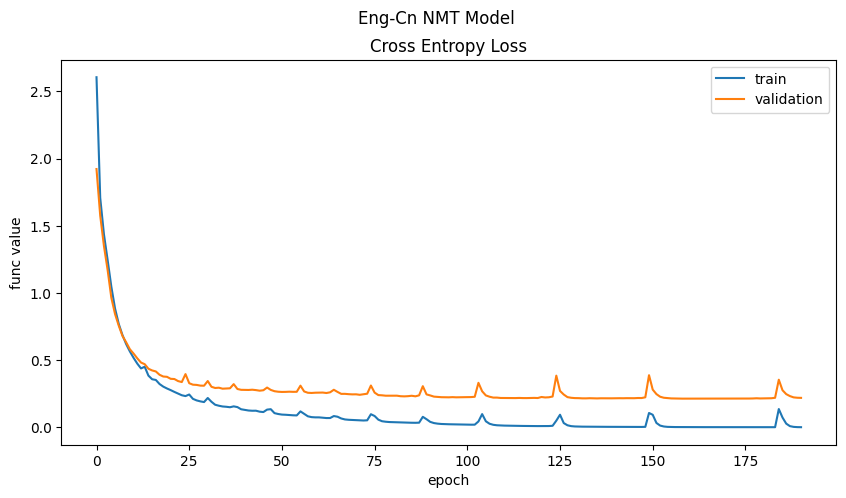

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# save model and its weights at a certain frequency
ckpt = ModelCheckpoint(
    filepath = "models/eng-cn_translator_v1.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True, # 只保存表現最好的（最低 val_loss）
    save_weights_only = False, # 儲存整個模型（包含架構 + 權重）
    save_freq = "epoch",
    mode = "min",
)
es = EarlyStopping(
    monitor = "loss",
    mode = "min",
    patience = 10
)

# train model
train_hist = eng_cn_translator.fit(X_train,y_train,batch_size = 64,epochs = 200,
                  validation_split = .2,verbose = 2,callbacks = [es, ckpt])

# preview training history
print("training history have info: {}".format(train_hist.history.keys())) # ['loss', 'val_loss']
fig, ax = plt.subplots(figsize = (10, 5))
fig.suptitle("Eng-Cn NMT Model")
ax.set_title("Cross Entropy Loss")
ax.plot(train_hist.history["loss"], label = "train")
ax.plot(train_hist.history["val_loss"], label = "validation")
ax.set_xlabel("epoch")
ax.set_ylabel("func value")
ax.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# load pre-trained model
eng_cn_translator = load_model("/content/gdrive/MyDrive/Colab Notebooks/models/eng-cn_translator_v1.h5")

In [ ]:
trans_seqs = eng_cn_translator.predict(
                X_test,
                batch_size = 60,
                verbose = 1,
            )
print(trans_seqs[0])

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step
[[8.9044942e-18 9.9999994e-01 1.3301916e-17 ... 3.8902063e-17
  3.7012157e-17 3.6826007e-15]
 [9.0189656e-13 3.8159946e-09 3.9731690e-14 ... 5.5781911e-17
  1.6438527e-19 3.5563102e-15]
 [2.3708494e-11 3.6700516e-09 2.1571672e-12 ... 5.6898280e-17
  2.1965539e-18 2.4841689e-15]
 ...
 [9.9999601e-01 7.7619627e-13 2.4501173e-06 ... 1.5407899e-14
  2.4270778e-15 1.7203973e-10]
 [9.9999601e-01 7.7139521e-13 2.4430524e-06 ... 1.5237804e-14
  2.4075014e-15 1.6982799e-10]
 [9.9999601e-01 7.6972559e-13 2.4420972e-06 ... 1.5150890e-14
  2.3972557e-15 1.6863497e-10]]
